# Name: Luke Pratley

# Data Wrangling and EDA
In this notebook I wrangle two distinct data sets, one for **building detection** and one for **road network detection**, and ultimately process and combine these into one cleaned dataset.

Some key points:
- The datasets were downloaded from a public AWS S3 bucket. See the pages for [buildings](https://spacenet.ai/spacenet-buildings-dataset-v2/) and [roads](https://spacenet.ai/spacenet-roads-dataset/) datasets for more information. The datasets were originally created for separate competitions hosted by [spacenet.ai](https://spacenet.ai/).
- The datasets are distinct **but** have overlapping area coverage. Each dataset contains satellite images and the labels are stored and geometry objects in a geopandas file.
- There are four different locations for each dataset [Las Vegas](https://spacenet.ai/las-vegas/), [Paris](https://spacenet.ai/paris/), [Shanghai](https://spacenet.ai/shanghai/), [Khartoum](https://spacenet.ai/khartoum/).
- A brief EDA is performed to understand the datasets.
- The images with many zero values were removed from the analysis.
- The RGB images are stored as a [GeoTIFF](https://en.wikipedia.org/wiki/GeoTIFF) format, this was read using the [rasterio](https://rasterio.readthedocs.io/en/latest/) package.
- The labels are stored as [shapely](https://github.com/shapely/shapely) geometry objects in a [geopandas](https://geopandas.org/en/stable/) DataFrame.
- The labels are converted to two boolean masks indicating if there building or road network on that pixel.

The cleaned and processed dataset is then ready for being feature engineered, which is done in the notebook `final_data_processing.ipynb`


## Data Acquisition
The data was downloaded from AWS s3 buckets. Note that the `.tar.gz` files can be upto 25 GB each, and more space is taken up when they are decompressed. There are

### AWS links to the Building Datasets

`aws s3 cp s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_2_Vegas.tar.gz .`

`aws s3 cp s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_3_Paris.tar.gz .`

`aws s3 cp s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_4_Shanghai.tar.gz .`

`aws s3 cp s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_5_Khartoum.tar.gz .`

The only folders that are kept after extraction are:
#### RGB Images
- `AOI_2_Vegas_Train\\RGB-PanSharpen`
- `AOI_3_Paris_Train\\RGB-PanSharpen`
- `AOI_4_Shanghai_Train\\RGB-PanSharpen`
- `AOI_5_Khartoum_Train\\RGB-PanSharpen`

#### geojson files
- `AOI_2_Vegas_Train\\geojson`
- `AOI_3_Paris_Train\\geojson`
- `AOI_4_Shanghai_Train\\geojson`
- `AOI_5_Khartoum_Train\\geojson`

#### Summary geojson file
- `AOI_2_Vegas_Train\\summaryData`
- `AOI_3_Paris_Train\\summaryData`
- `AOI_3_Shanghai_Train\\summaryData`
- `AOI_2_Khartoum_Train\\summaryData`

### Road Network Datasets

`aws s3 cp s3://spacenet-dataset/spacenet/SN3_roads/tarballs/SN3_roads_train_AOI_2_Vegas.tar.gz . `

`aws s3 cp s3://spacenet-dataset/spacenet/SN3_roads/tarballs/SN3_roads_train_AOI_3_Paris.tar.gz . `

`aws s3 cp s3://spacenet-dataset/spacenet/SN3_roads/tarballs/SN3_roads_train_AOI_4_Shanghai.tar.gz . `

`aws s3 cp s3://spacenet-dataset/spacenet/SN3_roads/tarballs/SN3_roads_train_AOI_5_Khartoum.tar.gz . `

The folders that are kept after extraction are:
#### RGB Images
- `AOI_2_Vegas\\PS-RGB`
- `AOI_3_Paris\\PS-RGB`
- `AOI_4_Shanghai\\PS-RGB`
- `AOI_2_Khartoum\\PS-RGB`

#### geojson files
- `AOI_2_Vegas\\geojson_roads`
- `AOI_3_Paris\\geojson_roads`
- `AOI_4_Shanghai\\geojson_roads`
- `AOI_2_Khartoum\\geojson_roads`

## EDA and data cleaning

First I import relevant packages. 
Note that I have added the directory to the python path to the python package that I have developed `building_road_segmentation`.

I use some functions in the package `building_road_segmentation`.

In [1]:
%matplotlib inline
import sys, os
sys.path.insert(0,os.path.abspath('../../building_road_segmentation'))

import building_road_segmentation.utilities

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import glob
import os

import shapely.wkt
import geopandas as gpd
import rasterio
import rasterio.features
from rasterio.merge import merge
from rasterio.plot import show
from shapely.geometry import box

Below I leverage the `glob` package to choose the data directory for processing. 

The building datasets are in the folders: 
- `AOI_2_Vegas_Train`,
- `AOI_3_Paris_Train`,
- `AOI_4_Shanghai_Train`,
- `AOI_5_Khartoum_Train`.

The road datasets are in the folders: 
- `AOI_2_Vegas`,
- `AOI_3_Paris`,
- `AOI_4_Shanghai`,
- `AOI_5_Khartoum`.

The output cleaned images and labels are stored in the folders:
- `final_images` the cleaned RGB images.
- `final_masks` the separate building and road boolean image masks that have the value true if there is a road or building respectively.

This notebook is run once for each Area of Interest (AOI). Below we are choosing the index for the Las Vegas area of interest. The `dataset_index` chooses the building dataset and the `road_dataset_index` chooses the road network dataset.

In [2]:
data_directory = 'D:\Capstone Project\data\\'
datasets = glob.glob(data_directory + '*')
datasets = [d.split('\\')[-1] for d in datasets]
road_dataset_index = 0
dataset_index = 1
display(datasets)
print()
print(f'We are cleaning the building dataset {datasets[dataset_index]}') 
print(f'We are cleaning the road dataset {datasets[road_dataset_index]}') 

['AOI_2_Vegas',
 'AOI_2_Vegas_Train',
 'AOI_3_Paris',
 'AOI_3_Paris_Train',
 'AOI_4_Shanghai',
 'AOI_4_Shanghai_Train',
 'AOI_5_Khartoum',
 'AOI_5_Khartoum_Train',
 'final_images',
 'final_masks',
 'SN2_buildings_train_AOI_2_Vegas.tar.gz',
 'SN2_buildings_train_AOI_3_Paris.tar.gz',
 'SN2_buildings_train_AOI_4_Shanghai.tar.gz',
 'SN2_buildings_train_AOI_5_Khartoum.tar.gz',
 'SN3_roads_train_AOI_2_Vegas.tar.gz',
 'SN3_roads_train_AOI_3_Paris.tar.gz',
 'SN3_roads_train_AOI_4_Shanghai.tar.gz',
 'SN3_roads_train_AOI_5_Khartoum.tar.gz']


We are cleaning the building dataset AOI_2_Vegas_Train
We are cleaning the road dataset AOI_2_Vegas


Below I am listing the directories in the dataset. There were more folders in the dataset. Due to space limitations I only kept the folders that are required.

In [3]:
directories = glob.glob(data_directory + f'{datasets[dataset_index]}\*')
directories.sort()

directories

['D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\RGB-PanSharpen',
 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\geojson',
 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\summaryData']

It is also useful to have a dictionary to that helps us choose the directories and their paths:

In [4]:
directories_dict = dict(zip([d.split('\\')[-1] for d in directories],directories))
directories_dict

{'RGB-PanSharpen': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\RGB-PanSharpen',
 'geojson': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\geojson',
 'summaryData': 'D:\\Capstone Project\\data\\AOI_2_Vegas_Train\\summaryData'}

## Data Cleaning and EDA for the Buildings Dataset

We start with reading a summary dataset for buildings.

In [5]:
building_info_df = gpd.read_file(glob.glob(directories[-1]+'\*')[0])

C:\Users\lukep\miniconda3\envs\tensorflow\lib\site-packages\geopandas\geodataframe.py:600: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


A quick look at this data set shows 5 columns.

In [6]:
building_info_df.head(5)

ImageId BuildingId  \
0  AOI_2_Vegas_img1209          1   
1  AOI_2_Vegas_img1209          2   
2  AOI_2_Vegas_img1209          3   
3  AOI_2_Vegas_img1209          4   
4  AOI_2_Vegas_img1209          5   

                                      PolygonWKT_Pix  \
0  POLYGON ((68.71 623.1 0,35.71 618.15 0,33.59 6...   
1  POLYGON ((221.33 645.02 0,185.7 640.33 0,184.4...   
2  POLYGON ((150.3 650.0 0,160.9 650.0 0,150.58 6...   
3  POLYGON ((141.86 636.02 0,98.99 630.03 0,99.57...   
4  POLYGON ((227.4 650.0 0,240.73 650.0 0,227.69 ...   

                                      PolygonWKT_Geo geometry  
0  POLYGON ((-115.27398708 36.20208033800003 0,-1...     None  
1  POLYGON ((-115.273575016999985 36.202021143000...     None  
2  POLYGON ((-115.273766779991007 36.202007699876...     None  
3  POLYGON ((-115.273789578999981 36.202045452000...     None  
4  POLYGON ((-115.273558615661273 36.202007699876...     None

The shape is below. There are 110042 rows.

In [7]:
building_info_df.shape

(110042, 5)

In [8]:
building_info_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 110042 entries, 0 to 110041
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   ImageId         110042 non-null  object  
 1   BuildingId      110042 non-null  object  
 2   PolygonWKT_Pix  110042 non-null  object  
 3   PolygonWKT_Geo  110042 non-null  object  
 4   geometry        0 non-null       geometry
dtypes: geometry(1), object(4)
memory usage: 4.2+ MB


### Column descriptions:
1. `ImageID`: The identification for an image file or directory.
2. `BuildingID`: The identification for a building label within one image.
3. `PolygonWKT_Pix`: The image pixel coordinates for the shape label.
4. `PolygonWKT_Geo`: The geospatial coordinates for the shape label.
5. `geometry`: An empty column.

The geometry column is completely filled with null values. The other columns don't have explicit null values, but we still need to check for badly defined entries.

Both the image and building ID columns should be integers. The Polygon columns can be converted into shapes.

We are changing the building ID to an integer then check if there are any negative values:

In [9]:
building_info_df['BuildingId'] = building_info_df['BuildingId'].astype(int)

In [10]:
building_info_df[building_info_df['BuildingId'] < 1]

ImageId  BuildingId PolygonWKT_Pix PolygonWKT_Geo geometry
512     AOI_2_Vegas_img2245          -1  POLYGON EMPTY  POLYGON EMPTY     None
1247     AOI_2_Vegas_img482          -1  POLYGON EMPTY  POLYGON EMPTY     None
2111      AOI_2_Vegas_img35          -1  POLYGON EMPTY  POLYGON EMPTY     None
3449     AOI_2_Vegas_img671          -1  POLYGON EMPTY  POLYGON EMPTY     None
4167    AOI_2_Vegas_img4819          -1  POLYGON EMPTY  POLYGON EMPTY     None
...                     ...         ...            ...            ...      ...
107093  AOI_2_Vegas_img4876          -1  POLYGON EMPTY  POLYGON EMPTY     None
107797  AOI_2_Vegas_img5047          -1  POLYGON EMPTY  POLYGON EMPTY     None
107829  AOI_2_Vegas_img1910          -1  POLYGON EMPTY  POLYGON EMPTY     None
108735  AOI_2_Vegas_img1164          -1  POLYGON EMPTY  POLYGON EMPTY     None
109524   AOI_2_Vegas_img971          -1  POLYGON EMPTY  POLYGON EMPTY     None

[235 rows x 5 columns]

We find that there are empty polygons for 235 rows!

We will now see if we should remove all of these rows by checking if they are all empty polygons.

In [11]:
building_info_df[building_info_df['BuildingId'] < 1]['PolygonWKT_Pix'].value_counts()

POLYGON EMPTY    235
Name: PolygonWKT_Pix, dtype: int64

In [12]:
building_info_df[building_info_df['BuildingId'] < 1]['PolygonWKT_Geo'].value_counts()

POLYGON EMPTY    235
Name: PolygonWKT_Geo, dtype: int64

They are all empty and we will drop these rows

In [13]:
building_info_df = building_info_df[building_info_df['BuildingId'] > 0]

We will now check if there are any other empty polygons.

In [14]:
building_info_df[building_info_df['PolygonWKT_Pix'] == 'POLYGON EMPTY']

ImageId  BuildingId PolygonWKT_Pix  \
9322    AOI_2_Vegas_img1198          49  POLYGON EMPTY   
17855   AOI_2_Vegas_img2672           2  POLYGON EMPTY   
32907    AOI_2_Vegas_img156          12  POLYGON EMPTY   
53586   AOI_2_Vegas_img3941          12  POLYGON EMPTY   
56860   AOI_2_Vegas_img4967          18  POLYGON EMPTY   
102773   AOI_2_Vegas_img966           1  POLYGON EMPTY   
105069   AOI_2_Vegas_img889          36  POLYGON EMPTY   

                                           PolygonWKT_Geo geometry  
9322    POLYGON ((-115.272417599930051 36.184352627988...     None  
17855   POLYGON ((-115.234576596138936 36.189722699852...     None  
32907   POLYGON ((-115.303509211572162 36.205517699883...     None  
53586   POLYGON ((-115.2057275997971 36.19824056360369...     None  
56860   POLYGON ((-115.184522266983819 36.196742699866...     None  
102773  POLYGON ((-115.2798818 36.23184270400003 0,-11...     None  
105069  POLYGON ((-115.281496853999954 36.213140674000...     None

In [15]:
building_info_df.drop(columns='PolygonWKT_Pix', axis=1, inplace=True)

We can drop the PolygonWKT_Pix column, since we are only interested in the PolygonWKT_Geo coordinates.

In [16]:
building_info_df[building_info_df['PolygonWKT_Geo'] == 'POLYGON EMPTY']

Empty GeoDataFrame
Columns: [ImageId, BuildingId, PolygonWKT_Geo, geometry]
Index: []

Now we are going to check for null values:

In [17]:
building_info_df.isna().sum()

ImageId                0
BuildingId             0
PolygonWKT_Geo         0
geometry          109807
dtype: int64

There are no null values except for geometry.

In [18]:
pd.DataFrame(building_info_df['geometry']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109807 entries, 0 to 110041
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  0 non-null      geometry
dtypes: geometry(1)
memory usage: 1.7 MB


All of the values are null. I am not sure what the column is for, but I am thinking I will drop it for now since I am not sure why it is useful as it is.

In [19]:
building_info_df.drop(columns=['geometry'], axis=1, inplace=True)

In [20]:
building_info_df.head(10)

ImageId  BuildingId  \
0  AOI_2_Vegas_img1209           1   
1  AOI_2_Vegas_img1209           2   
2  AOI_2_Vegas_img1209           3   
3  AOI_2_Vegas_img1209           4   
4  AOI_2_Vegas_img1209           5   
5  AOI_2_Vegas_img1209           6   
6  AOI_2_Vegas_img1209           7   
7  AOI_2_Vegas_img1209           8   
8  AOI_2_Vegas_img1209           9   
9  AOI_2_Vegas_img1209          10   

                                      PolygonWKT_Geo  
0  POLYGON ((-115.27398708 36.20208033800003 0,-1...  
1  POLYGON ((-115.273575016999985 36.202021143000...  
2  POLYGON ((-115.273766779991007 36.202007699876...  
3  POLYGON ((-115.273789578999981 36.202045452000...  
4  POLYGON ((-115.273558615661273 36.202007699876...  
5  POLYGON ((-115.27417259993355 36.2025144913411...  
6  POLYGON ((-115.273968876999959 36.202492435000...  
7  POLYGON ((-115.272754125999938 36.202167611000...  
8  POLYGON ((-115.273366127999964 36.202400240000...  
9  POLYGON ((-115.273156992999986 36.202357965000...

In [21]:
building_info_df.head()

ImageId  BuildingId  \
0  AOI_2_Vegas_img1209           1   
1  AOI_2_Vegas_img1209           2   
2  AOI_2_Vegas_img1209           3   
3  AOI_2_Vegas_img1209           4   
4  AOI_2_Vegas_img1209           5   

                                      PolygonWKT_Geo  
0  POLYGON ((-115.27398708 36.20208033800003 0,-1...  
1  POLYGON ((-115.273575016999985 36.202021143000...  
2  POLYGON ((-115.273766779991007 36.202007699876...  
3  POLYGON ((-115.273789578999981 36.202045452000...  
4  POLYGON ((-115.273558615661273 36.202007699876...

We check for duplicates and find none.

In [22]:
building_info_df[building_info_df.duplicated()]

Empty DataFrame
Columns: [ImageId, BuildingId, PolygonWKT_Geo]
Index: []

Below we convert the geometry column into a geometry object datatype.

In [23]:
building_info_df["PolygonWKT_Geo"] = building_info_df["PolygonWKT_Geo"].apply(lambda x: shapely.wkt.loads(x))

Since it is the only geometry column, we change the column name to geometry.

In [24]:
building_info_df.rename(columns={'PolygonWKT_Geo' :'geometry'}, inplace=True)

For saving later, we need to set which column has a type of geometry in the geopandas DataFrame.

In [25]:
building_info_df.set_geometry(col='geometry', inplace=True)

In [26]:
building_info_df

ImageId  BuildingId  \
0       AOI_2_Vegas_img1209           1   
1       AOI_2_Vegas_img1209           2   
2       AOI_2_Vegas_img1209           3   
3       AOI_2_Vegas_img1209           4   
4       AOI_2_Vegas_img1209           5   
...                     ...         ...   
110037  AOI_2_Vegas_img4107           4   
110038  AOI_2_Vegas_img4107           5   
110039  AOI_2_Vegas_img4107           6   
110040  AOI_2_Vegas_img4107           7   
110041  AOI_2_Vegas_img2131           1   

                                                 geometry  
0       POLYGON Z ((-115.27399 36.20208 0.00000, -115....  
1       POLYGON Z ((-115.27358 36.20202 0.00000, -115....  
2       POLYGON Z ((-115.27377 36.20201 0.00000, -115....  
3       POLYGON Z ((-115.27379 36.20205 0.00000, -115....  
4       POLYGON Z ((-115.27356 36.20201 0.00000, -115....  
...                                                   ...  
110037  POLYGON Z ((-115.20222 36.21116 0.00000, -115....  
110038  POLYGON Z ((-115.20222 36.21157 0.00000, -115....  
110039  POLYGON Z ((-115.20225 36.21213 0.00000, -115....  
110040  POLYGON Z ((-115.20309 36.21214 0.00000, -115....  
110041  POLYGON Z ((-115.24654 36.17569 0.00000, -115....  

[109807 rows x 3 columns]

Below we plot the number of building IDs per image.

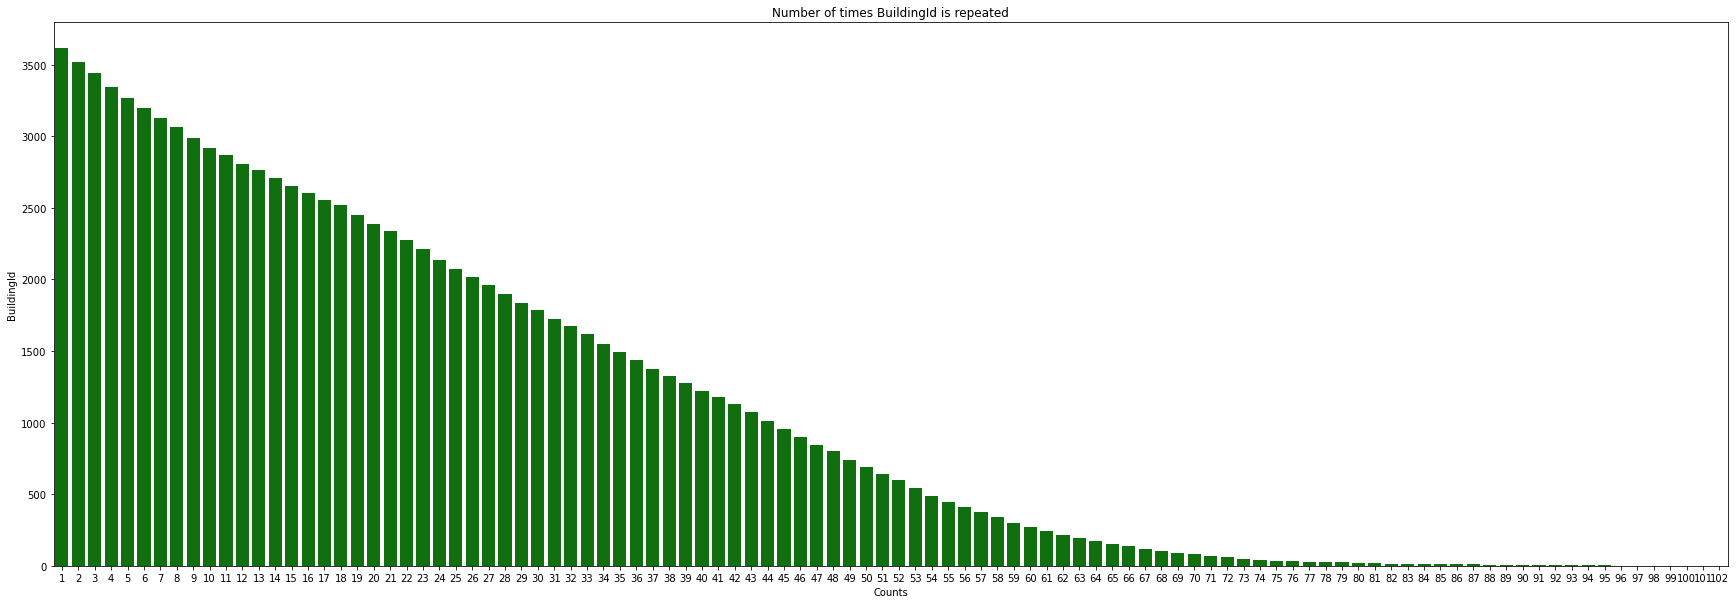

In [27]:
plt.figure(figsize=(30, 10))
plt.title('Number of times BuildingId is repeated')
sns.barplot(data=pd.DataFrame(building_info_df['BuildingId']).value_counts().reset_index(), x='BuildingId', y=0, color = 'green')
plt.ylabel('BuildingId')
plt.xlabel('Counts')
plt.show()

It turns out that we expect the duplicate BuildingIds, because the ID is image specific. This means two buildings with the same ID are different if they are in different images.

Now we want to save this dataframe because we will need it when cross matching buildings in the roads dataset.

In [28]:
image_names = np.array(building_info_df['ImageId'].unique().astype(str))
image_names.sort()
print(f'We expect to have this many images (of a given type): {image_names.shape[0]}')

We expect to have this many images (of a given type): 3616


Lastly, we are going to check that a BuildingId does not appear twice within the same image.

In [29]:
for im in image_names:
    if building_info_df[building_info_df['ImageId'] == im]['BuildingId'].duplicated().sum() > 0:
        print(f'{im} has at least one duplicate BuildingId. You need to investigate!')

Now we save smaller geopandas dictionaries, one for each image ID:

In [30]:
for im in image_names:
    file_path = f'{directories_dict["geojson"]}\\buildings\\buildings_{im}.geojson'
    building_info_df[building_info_df['ImageId'] == im].to_file(file_path, driver='GeoJSON')

C:\Users\lukep\miniconda3\envs\tensorflow\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\lukep\miniconda3\envs\tensorflow\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\lukep\miniconda3\envs\tensorflow\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\lukep\miniconda3\envs\tensorflow\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype in

Now we are going to investigate the image directories. We can check that all of the files we expect exist from the `image_names` list that we created.

We are using a custom function that takes this dictionary and creates a path from a given folder name and image name.

Below we are checking that none of the image files or geopandas dictionaries are missing:

In [31]:
for im in image_names:
    for key, item in directories_dict.items():
        if key != 'geojson':
            file_path =  f'{directories_dict["RGB-PanSharpen"]}\\RGB-PanSharpen_{im}.tif'
            if not os.path.exists(file_path):
                print(f'{file_path} does not exist')
        elif key == 'geojson':
            file_path = f'{directories_dict["geojson"]}\\buildings\\buildings_{im}.geojson'
            if not os.path.exists(file_path):
                print(f'{file_path} does not exist')

We can check what the type and shape is for each image:

In [32]:
shape_dictionary = dict()
for key, item in directories_dict.items():
    if key != 'geojson':
        file_path =  f'{directories_dict["RGB-PanSharpen"]}\\RGB-PanSharpen_{im}.tif'
        with rasterio.open(file_path) as image:
            shape_dictionary[key] = image.read().shape
            print(type(image))
            print(type(image.read()))
shape_dictionary

<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>


{'RGB-PanSharpen': (3, 650, 650), 'summaryData': (3, 650, 650)}

From the SpaceNet.ai website, we expect our observations to be of the form:


PS-RGB         > Raw source geotiffs of RGB raster data from Worldview-3 pansharpened to 0.3m

The images have a shape of (3, 650, 650). The first index is the RGB channels, the last two are width and height pixels.



Below we view one of the images with coordinates:

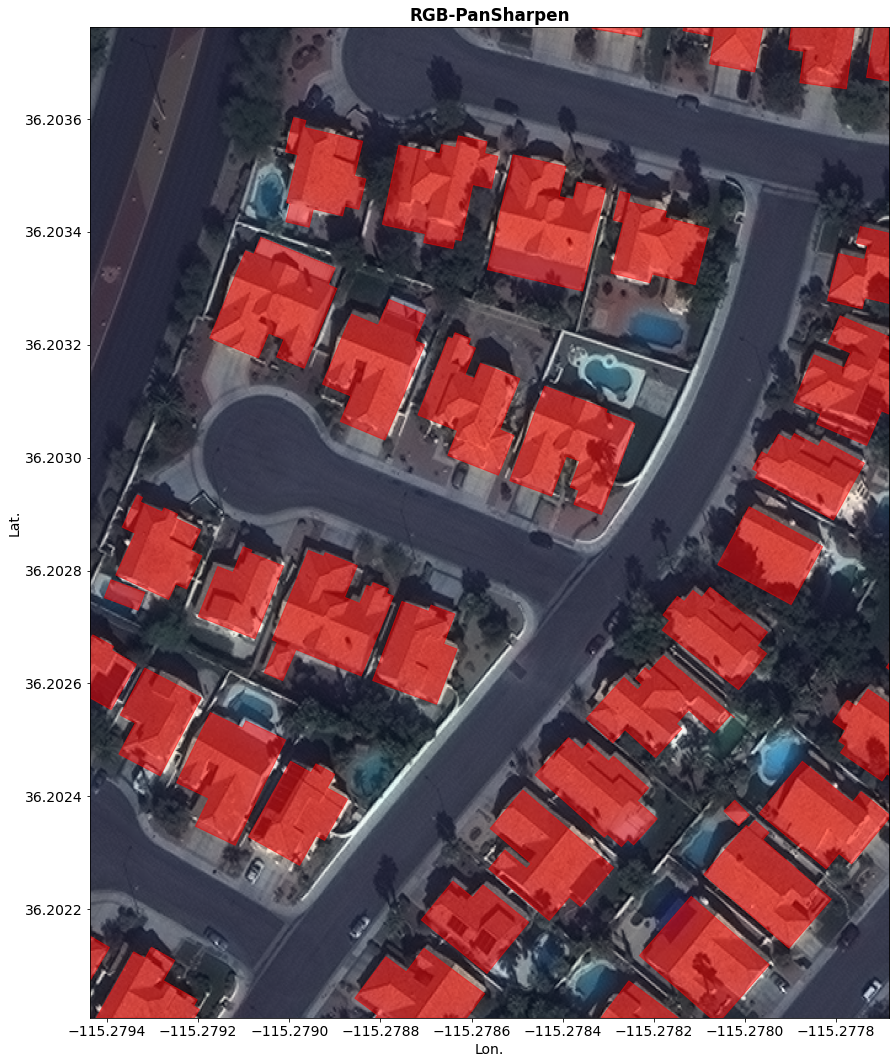

In [33]:
building_road_segmentation.utilities.plot_image(directories_dict, image_names[10], figsize=(15, 15))

The above plot was mading using the geopandas dictionary:

In [34]:
building_road_segmentation.utilities.get_geopandas_for_image(directories_dict, image_names[10])

ImageId  BuildingId  \
0   AOI_2_Vegas_img1015           1   
1   AOI_2_Vegas_img1015           2   
2   AOI_2_Vegas_img1015           3   
3   AOI_2_Vegas_img1015           4   
4   AOI_2_Vegas_img1015           5   
5   AOI_2_Vegas_img1015           6   
6   AOI_2_Vegas_img1015           7   
7   AOI_2_Vegas_img1015           8   
8   AOI_2_Vegas_img1015           9   
9   AOI_2_Vegas_img1015          10   
10  AOI_2_Vegas_img1015          11   
11  AOI_2_Vegas_img1015          12   
12  AOI_2_Vegas_img1015          13   
13  AOI_2_Vegas_img1015          14   
14  AOI_2_Vegas_img1015          15   
15  AOI_2_Vegas_img1015          16   
16  AOI_2_Vegas_img1015          17   
17  AOI_2_Vegas_img1015          18   
18  AOI_2_Vegas_img1015          19   
19  AOI_2_Vegas_img1015          20   
20  AOI_2_Vegas_img1015          21   
21  AOI_2_Vegas_img1015          22   
22  AOI_2_Vegas_img1015          23   
23  AOI_2_Vegas_img1015          24   
24  AOI_2_Vegas_img1015          25   
25  AOI_2_Vegas_img1015          26   
26  AOI_2_Vegas_img1015          27   
27  AOI_2_Vegas_img1015          28   
28  AOI_2_Vegas_img1015          29   
29  AOI_2_Vegas_img1015          30   
30  AOI_2_Vegas_img1015          31   
31  AOI_2_Vegas_img1015          32   
32  AOI_2_Vegas_img1015          33   
33  AOI_2_Vegas_img1015          34   
34  AOI_2_Vegas_img1015          35   
35  AOI_2_Vegas_img1015          36   
36  AOI_2_Vegas_img1015          37   
37  AOI_2_Vegas_img1015          38   
38  AOI_2_Vegas_img1015          39   
39  AOI_2_Vegas_img1015          40   
40  AOI_2_Vegas_img1015          41   

                                             geometry  
0   POLYGON Z ((-115.27768 36.20367 0.00000, -115....  
1   POLYGON Z ((-115.27776 36.20376 0.00000, -115....  
2   POLYGON Z ((-115.27796 36.20376 0.00000, -115....  
3   POLYGON Z ((-115.27822 36.20376 0.00000, -115....  
4   POLYGON Z ((-115.27883 36.20349 0.00000, -115....  
5   POLYGON Z ((-115.27857 36.20356 0.00000, -115....  
6   POLYGON Z ((-115.27841 36.20346 0.00000, -115....  
7   POLYGON Z ((-115.27808 36.20341 0.00000, -115....  
8   POLYGON Z ((-115.27906 36.20339 0.00000, -115....  
9   POLYGON Z ((-115.27870 36.20325 0.00000, -115....  
10  POLYGON Z ((-115.27860 36.20321 0.00000, -115....  
11  POLYGON Z ((-115.27824 36.20306 0.00000, -115....  
12  POLYGON Z ((-115.27933 36.20292 0.00000, -115....  
13  POLYGON Z ((-115.27901 36.20281 0.00000, -115....  
14  POLYGON Z ((-115.27875 36.20275 0.00000, -115....  
15  POLYGON Z ((-115.27900 36.20246 0.00000, -115....  
16  POLYGON Z ((-115.27917 36.20255 0.00000, -115....  
17  POLYGON Z ((-115.27919 36.20257 0.00000, -115....  
18  POLYGON Z ((-115.27944 36.20268 0.00000, -115....  
19  POLYGON Z ((-115.27930 36.20213 0.00000, -115....  
20  POLYGON Z ((-115.27944 36.20215 0.00000, -115....  
21  POLYGON Z ((-115.27870 36.20213 0.00000, -115....  
22  POLYGON Z ((-115.27864 36.20225 0.00000, -115....  
23  POLYGON Z ((-115.27832 36.20201 0.00000, -115....  
24  POLYGON Z ((-115.27829 36.20227 0.00000, -115....  
25  POLYGON Z ((-115.27795 36.20210 0.00000, -115....  
26  POLYGON Z ((-115.27798 36.20236 0.00000, -115....  
27  POLYGON Z ((-115.27839 36.20250 0.00000, -115....  
28  POLYGON Z ((-115.27808 36.20277 0.00000, -115....  
29  POLYGON Z ((-115.27783 36.20284 0.00000, -115....  
30  POLYGON Z ((-115.27786 36.20245 0.00000, -115....  
31  POLYGON Z ((-115.27773 36.20259 0.00000, -115....  
32  POLYGON Z ((-115.27768 36.20262 0.00000, -115....  
33  POLYGON Z ((-115.27768 36.20327 0.00000, -115....  
34  POLYGON Z ((-115.27768 36.20308 0.00000, -115....  
35  POLYGON Z ((-115.27789 36.20304 0.00000, -115....  
36  POLYGON Z ((-115.27939 36.20278 0.00000, -115....  
37  POLYGON Z ((-115.27896 36.20284 0.00000, -115....  
38  POLYGON Z ((-115.27801 36.20235 0.00000, -115....  
39  POLYGON Z ((-115.27803 36.20254 0.00000, -115....  
40  POLYGON Z ((-115.27803 36.20254 0.00000, -115....

## Saving the RGB Images for the Building Dataset

Below we swap the RGB axis of the image and save it as a numpy file. The axis goes from (channels, height, width) to (height, width, channels):

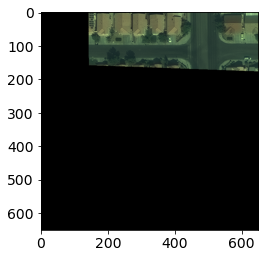

AOI_2_Vegas_img1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


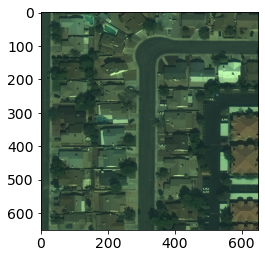

AOI_2_Vegas_img2593


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


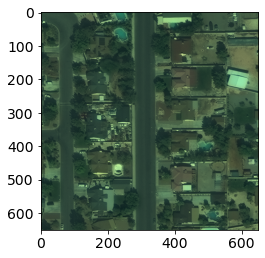

AOI_2_Vegas_img4124


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


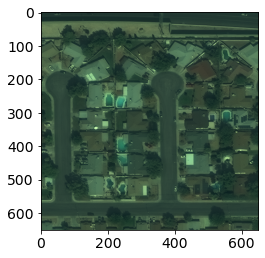

AOI_2_Vegas_img5745


In [35]:
count  = 0
for k, im in enumerate(image_names):
    path = f'D:\\Capstone Project\\data\\final_images\\{im}.npy'
    with rasterio.open(building_road_segmentation.utilities.get_image_path(directories_dict, 'RGB-PanSharpen', im)) as image:
        np.save(path, np.moveaxis(image.read(), 0, 2))
        if count % 1000 == 0:
            plt.imshow(np.moveaxis(image.read(), 0, 2)/1800)
            plt.show()
            print(im)
    count += 1

## Building Feature Engineering for the Building Dataset

We need to create images for the masks that the ML method will predict, e.g., True or False values across all pixels for buildings. Below we use functionality from rasterio to do this with the geometry object from geopandas. We plot the process of creating one of these masks:

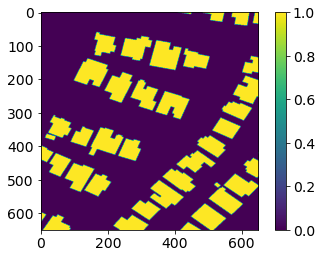

In [36]:
file_path =  f'{directories_dict["RGB-PanSharpen"]}\\RGB-PanSharpen_{image_names[10]}.tif'
with rasterio.open(file_path) as image:
    gpandas_path = f'{directories_dict["geojson"]}\\buildings\\buildings_{image_names[10]}.geojson'
    mask = rasterio.features.geometry_mask(gpd.read_file(gpandas_path)['geometry'], image.shape, image.transform, all_touched=False, invert=True)
    plt.imshow(mask)
    plt.colorbar()

We now create masks and save the output for each image. We display an example of a mask at every 1000 images.

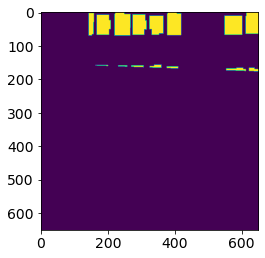

D:\Capstone Project\data\final_masks\building_mask_AOI_2_Vegas_img1.npy


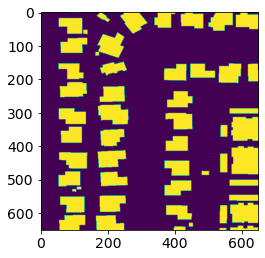

D:\Capstone Project\data\final_masks\building_mask_AOI_2_Vegas_img2593.npy


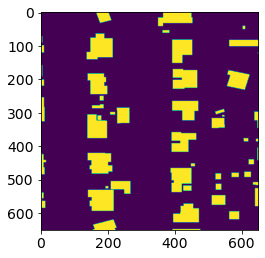

D:\Capstone Project\data\final_masks\building_mask_AOI_2_Vegas_img4124.npy


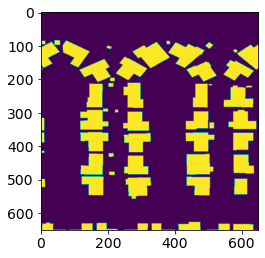

D:\Capstone Project\data\final_masks\building_mask_AOI_2_Vegas_img5745.npy


In [37]:
count  = 0
for k, im in enumerate(image_names):
    path = f'D:\\Capstone Project\\data\\final_masks\\building_mask_{im}.npy'
    image_path =  f'{directories_dict["RGB-PanSharpen"]}\\RGB-PanSharpen_{im}.tif'
    with rasterio.open(image_path) as image:
        gpandas_path = f'{directories_dict["geojson"]}\\buildings\\buildings_{im}.geojson'
        mask = rasterio.features.geometry_mask(gpd.read_file(gpandas_path)['geometry'], image.shape, image.transform, all_touched=False, invert=True)
        np.save(path, mask)
    if count % 1000 == 0:
        plt.imshow(mask)
        plt.show()
        print(path)
    count += 1

### Next we would make the road masks. However, we first need to process the road dataset. For this reason, the road masks for the building dataset are created in the final step of this notebook.

## Data cleaning and EDA for Road Dataset

First we make sure we have chosen the right road directory for cleaning

In [38]:
print(f'We are cleaning the road dataset {datasets[road_dataset_index]}') 

We are cleaning the road dataset AOI_2_Vegas


Now we set up the directories and dictionary for the directories:

In [39]:
road_directories = glob.glob(data_directory + f'{datasets[road_dataset_index]}\*')
road_directories.sort()

road_directories

['D:\\Capstone Project\\data\\AOI_2_Vegas\\PS-RGB',
 'D:\\Capstone Project\\data\\AOI_2_Vegas\\geojson_roads']

In [40]:
road_directories_dict = dict(zip([d.split('\\')[-1] for d in road_directories],road_directories))
road_directories_dict

{'PS-RGB': 'D:\\Capstone Project\\data\\AOI_2_Vegas\\PS-RGB',
 'geojson_roads': 'D:\\Capstone Project\\data\\AOI_2_Vegas\\geojson_roads'}

Now we read in the individual geopandas datasets that contain information about the roads:

In [41]:
geojson_files = [gpd.read_file(k) for k in glob.glob(road_directories_dict['geojson_roads'] + '\*')]

We can take a quick look at one of the files:

In [42]:
geojson_files[10]

bridge_typ heading lane_numbe lane_number one_way_ty paved  road_id  \
0           2       0          2           2          2     1    15232   
1           2       0          2           2          2     1     1933   
2           2       0          2           2          2     1     2960   
3           2       0          2           2          2     1     7420   
4           2       0          2           2          2     1    15040   
5           2       0          2           2          2     1    22817   
6           2       0          2           2          2     1    20363   
7           2       0          2           2          2     1     3681   
8           2       0          2           2          2     1    18846   
9           2       0          2           2          2     1     6402   
10          2       0          2           2          2     1     1402   
11          2       0          2           2          2     1    19760   

   road_type  origarea   origlen  partialDec  truncated  \
0          5         0  0.000531           1          0   
1          5         0  0.001271           1          0   
2          6         0  0.002088           1          0   
3          6         0  0.003705           1          0   
4          5         0  0.006065           1          0   
5          5         0  0.007829           1          0   
6          5         0  0.006015           1          0   
7          5         0  0.001440           1          0   
8          3         0  0.010325           1          0   
9          5         0  0.006786           1          0   
10         5         0  0.004475           1          0   
11         5         0  0.001210           1          0   

                                             geometry  
0   LINESTRING (-115.20320 36.13879, -115.20320 36...  
1   LINESTRING (-115.20411 36.13877, -115.20411 36...  
2   LINESTRING (-115.20296 36.13536, -115.20272 36...  
3   LINESTRING (-115.20497 36.13532, -115.20496 36...  
4   LINESTRING (-115.20550 36.13726, -115.20551 36...  
5   LINESTRING (-115.20222 36.13556, -115.20222 36...  
6   LINESTRING (-115.20533 36.13727, -115.20531 36...  
7   LINESTRING (-115.20549 36.13707, -115.20573 36...  
8   LINESTRING (-115.20573 36.13726, -115.20550 36...  
9   LINESTRING (-115.20545 36.13726, -115.20545 36...  
10  LINESTRING (-115.20222 36.13808, -115.20224 36...  
11  LINESTRING (-115.20454 36.13876, -115.20454 36...

We can see information about the types of roads! We are also not interested in the majority of the columns. 

We are interested in `geometry` and maybe `road_id`.

One major issue is that we don't have any way to inspect the image ids. We will have to build up our image ids for our road images manually.

Below we concatenate all of the files:

In [43]:
road_df = pd.concat(geojson_files, axis=0, ignore_index=True)

In [44]:
road_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20771 entries, 0 to 20770
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   bridge_typ   20771 non-null  object  
 1   heading      20771 non-null  object  
 2   lane_numbe   20771 non-null  object  
 3   lane_number  20771 non-null  object  
 4   one_way_ty   20771 non-null  object  
 5   paved        20771 non-null  object  
 6   road_id      20771 non-null  int64   
 7   road_type    20771 non-null  object  
 8   origarea     20771 non-null  int64   
 9   origlen      20771 non-null  float64 
 10  partialDec   20771 non-null  int64   
 11  truncated    20771 non-null  int64   
 12  geometry     20771 non-null  geometry
dtypes: float64(1), geometry(1), int64(4), object(7)
memory usage: 2.1+ MB


There are no null entries.

In [45]:
road_df.head()

bridge_typ heading lane_numbe lane_number one_way_ty paved  road_id  \
0          2       0          2           2          2     1    11412   
1          2       0          2           2          2     1     4971   
2          2       0          2           2          2     1    12648   
3          2       0          2           2          2     1     9420   
4          2       0          2           2          2     1    15893   

  road_type  origarea   origlen  partialDec  truncated  \
0         5         0  0.000113           1          0   
1         5         0  0.000763           1          0   
2         5         0  0.000781           1          0   
3         5         0  0.000779           1          0   
4         5         0  0.000890           1          0   

                                            geometry  
0  LINESTRING (-115.30618 36.12799, -115.30618 36...  
1  LINESTRING (-115.30544 36.12797, -115.30468 36...  
2  LINESTRING (-115.30401 36.12797, -115.30468 36...  
3  LINESTRING (-115.30544 36.12801, -115.30544 36...  
4  LINESTRING (-115.30707 36.12800, -115.30618 36...

Now we check if any of the geometries are empty.

In [46]:
road_df['geometry'].map(lambda x: x.is_empty).sum()

0

We now create an array of image paths for accessing the images for the road dataset:

In [47]:
road_image_paths = glob.glob(road_directories_dict['PS-RGB'] + '\\*')

In [48]:
road_image_paths[:5]

['D:\\Capstone Project\\data\\AOI_2_Vegas\\PS-RGB\\SN3_roads_train_AOI_2_Vegas_PS-RGB_img1.tif',
 'D:\\Capstone Project\\data\\AOI_2_Vegas\\PS-RGB\\SN3_roads_train_AOI_2_Vegas_PS-RGB_img10.tif',
 'D:\\Capstone Project\\data\\AOI_2_Vegas\\PS-RGB\\SN3_roads_train_AOI_2_Vegas_PS-RGB_img100.tif',
 'D:\\Capstone Project\\data\\AOI_2_Vegas\\PS-RGB\\SN3_roads_train_AOI_2_Vegas_PS-RGB_img1001.tif',
 'D:\\Capstone Project\\data\\AOI_2_Vegas\\PS-RGB\\SN3_roads_train_AOI_2_Vegas_PS-RGB_img1002.tif']

We view one of these images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1300, 1300)


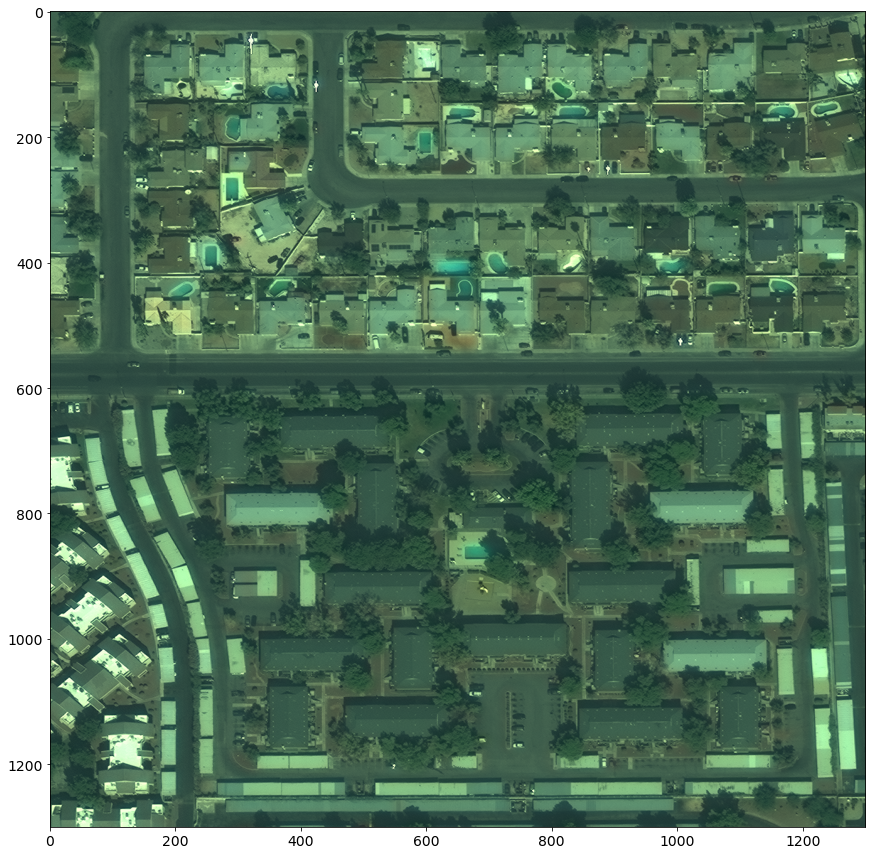

In [49]:
with rasterio.open(road_image_paths[10]) as image:
    plt.figure(figsize=(15, 15))
    plt.imshow(np.moveaxis(image.read(), 0, 2)/1400.)
    print(image.read().shape)

First you can see that the images dimensions are twice the size for the road dataset when compared to the building dataset. 
This means that we need to cut each image into quarters and then saved separately. Unlike the building dataset where we can process the RGB image, building and road masks seperately, for the road data set we need to use the large RGB image to create road and building masks. Once we have the large RGB image with road and building masks, we can cut them into quarters and save them as .npy files.

## Saving the RGB Images for the Road Dataset with Building and Road Feature Engineering.

Below we loop through the RGB images and create masks from road and building geopandas DataFrame geometry columns.

One issue is that we don't know what what geometry objects overlap with the image region prior to the mask creation. This can slow down the mask making process given that there are 20,000 road objects and about 100,000 building objects. This was not an issue when we knew the image ID for each object.

One way to speed up the process is the calculation of the variables in the loop `road_overlap` and `building_overlap`. These variables filter the DataFrame to objects that overlap with the image region prior to creating the masks.

If there are no road or building objects that overlap with the image, the output value for pixels is `-1`. This value of `-1` can be used during the learning process, to censor that particular label. For example, some images have building labels available but do not have road labels available. In this case, we can censor the road label during learning while still updating the weights in back-propagation for the building labels.

In [51]:
from shapely.geometry import box
key ='MS'
for images in road_image_paths:
    with rasterio.open(images) as image:
        image_name = images.split('\\')[-1].replace('.tif', '')
        # The image region bounds as a shape
        bounds = box(*image.bounds)
        #We vectorize a function for checking of the bounds overlap with a geometry object
        check_bounds =  np.vectorize(lambda x : x.intersects(bounds))
        # We have boolean lists for roads and buildings that overlap
        building_overlap = check_bounds(building_info_df['geometry'])
        road_overlap = check_bounds(road_df['geometry'])
        
        #swaping axis and normalizing the image for viewing
        img = image.read()
        img = np.moveaxis(img, 0, 2)
        img = img/1800
        
        #creating the masks
        if road_overlap.sum() > 0:
            road_mask = rasterio.features.geometry_mask(road_df['geometry'][road_overlap], image.shape, image.transform, all_touched=False, invert=True)
        else:
            road_mask = -1 * np.ones((img.shape[0], img.shape[1]))
            
        if building_overlap.sum() > 0:
            building_mask = rasterio.features.geometry_mask(building_info_df['geometry'][building_overlap], image.shape, image.transform, all_touched=False, invert=True)
        else:
            building_mask = -1 * np.ones((img.shape[0], img.shape[1]))
        
        # Spliting the images and masks into 4 components
        patch_size= (int(img.shape[0]/2), int(img.shape[1]/2))
        patches = [img[:(patch_size[0]),:(patch_size[1])], 
                   img[patch_size[0]:(2 * patch_size[0]),:(patch_size[1])], 
                   img[patch_size[0]:(2 * patch_size[0]), patch_size[1]:(2 * patch_size[1])],
                   img[:(patch_size[0]), patch_size[1]:(2 * patch_size[1])],
                  ]
        road_mask_patches = [road_mask[:(patch_size[0]),:(patch_size[1])], 
                   road_mask[patch_size[0]:(2 * patch_size[0]),:(patch_size[1])], 
                   road_mask[patch_size[0]:(2 * patch_size[0]), patch_size[1]:(2 * patch_size[1])],
                   road_mask[:(patch_size[0]), patch_size[1]:(2 * patch_size[1])]
                  ]
        building_mask_patches = [building_mask[:(patch_size[0]),:(patch_size[1])], 
                   building_mask[patch_size[0]:(2 * patch_size[0]),:(patch_size[1])], 
                   building_mask[patch_size[0]:(2 * patch_size[0]), patch_size[1]:(2 * patch_size[1])],
                   building_mask[:(patch_size[0]), patch_size[1]:(2 * patch_size[1])]
                  ]
        #saving the images and masks as .npy files
        for k, a in enumerate(['a', 'b', 'c', 'd']):
            path = f'D:\\Capstone Project\\data\\final_masks\\road_mask_{image_name}_{a}.npy'
            np.save(path, road_mask_patches[k])
        for k, a in enumerate(['a', 'b', 'c', 'd']):
            path = f'D:\\Capstone Project\\data\\final_masks\\building_mask_{image_name}_{a}.npy'
            np.save(path, building_mask_patches[k])
        for k, a in enumerate(['a', 'b', 'c', 'd']):
            path = f'D:\\Capstone Project\\data\\final_images\\{image_name}_{a}.npy'
            np.save(path, patches[k])

## Road Feature Engineering for the Building Dataset

In this section we are reading in the roads geopandas data and creating masks for the buildings dataset. 

We use the same filtering process as before to speed up the mask creation process.

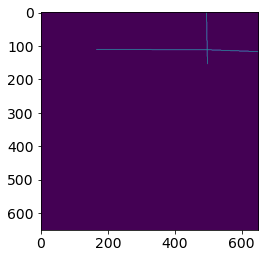

D:\Capstone Project\data\final_masks\road_mask_AOI_2_Vegas_img1.npy


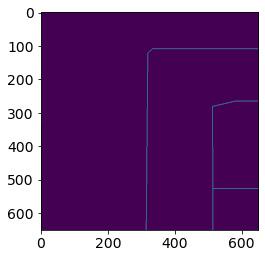

D:\Capstone Project\data\final_masks\road_mask_AOI_2_Vegas_img2593.npy


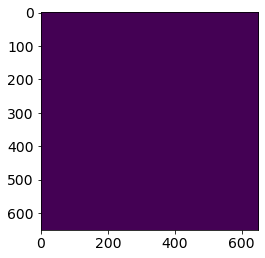

D:\Capstone Project\data\final_masks\road_mask_AOI_2_Vegas_img4124.npy


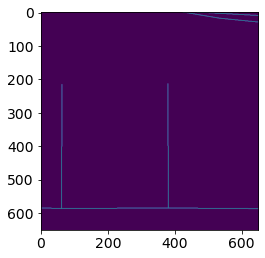

D:\Capstone Project\data\final_masks\road_mask_AOI_2_Vegas_img5745.npy


In [53]:
count = 0
image_dirs = glob.glob(directories_dict['RGB-PanSharpen'] + '\\*')
image_dirs.sort()
for image_name in image_names:
    image_path =  f'{directories_dict["RGB-PanSharpen"]}\\RGB-PanSharpen_{image_name}.tif'
    with rasterio.open(image_path) as image:
        path = f'D:\\Capstone Project\\data\\final_masks\\road_mask_{image_name}.npy'
        bounds = box(*image.bounds)
        check_bounds =  np.vectorize(lambda x : bounds.intersects(x))
        road_overlap = check_bounds(road_df['geometry'])
        img = image.read()
        img = np.moveaxis(img, 0, 2)
        if road_overlap.sum() > 0:
            road_mask = rasterio.features.geometry_mask(road_df['geometry'][road_overlap], image.shape, image.transform, all_touched=False, invert=True)
        else:
            road_mask = -1 * np.ones((img.shape[0], img.shape[1]))
        np.save(path, road_mask)
        if count % 1000 == 0:
            plt.imshow(road_mask)
            plt.show()
            print(path)
        count += 1
        

## See the `final_data_processing.ipynb` notebook for more feature engineering and processing prior to the training process.